In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
print(X.iloc[0, :])
print(y[:10])

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64
0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [6]:
y = y.astype(np.uint8)

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [8]:
enc.fit(y[:,np.newaxis])

<ipython-input-8-78fc683d5810>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  enc.fit(y[:,np.newaxis])


OneHotEncoder()

In [9]:
Y = enc.transform(y[:,np.newaxis]).toarray()

<ipython-input-9-fd377ab0d802>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.transform(y[:,np.newaxis]).toarray()


In [10]:
Y.shape

(70000, 10)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [12]:
X_train = X_train / 255
X_test = X_test / 255

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [14]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [15]:
# add L2 regularization
def compute_cost(X, T, W, Lambda=0):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + 1 / 2 * Lambda * np.sum(W ** 2)
    return cost

In [16]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [17]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size, Lambda=0):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        W = W - (learning_rate/batch_size) * ((X_batch.T @ (softmax(X_batch, W) - T_batch)) + Lambda * W) # https://sanghyu.tistory.com/88
        cost_history[i] = compute_cost(X_batch, T_batch, W, Lambda)
        if i % 10000 == 0:
            print(f'{i}번째 loss값: {cost_history[i][0]}')

    return (cost_history, W)

In [18]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 50000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64)

Initial Cost is: 2.302485097993735 

0번째 loss값: 2.2712498052523706
10000번째 loss값: 0.19239540740429462
20000번째 loss값: 0.5106365151279849
30000번째 loss값: 0.1856552035736016
40000번째 loss값: 0.4924162890692729


In [19]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.9114


In [20]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 50000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W, 0)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))
print('-------------------')

scores = []
lambda_list = [-0.1, -0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01, 0.03, 0.05, 0.1, 0.5]

for lamb in lambda_list:
  print('====================')
  print(f'Lambda : {lamb}')
  (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, lamb)
  y_pred = predict(X, W_optimal)
  score = float(sum(y_pred == np.argmax(T, axis=1)))/ float(len(y_pred))
  scores.append(score)

Initial Cost is: 2.302485097993735 

-------------------
Lambda : -0.1
0번째 loss값: 2.283250833583219
10000번째 loss값: -2.9803442639812063
20000번째 loss값: -4.868431915619695
30000번째 loss값: -7.097487211329485
40000번째 loss값: -9.737048495600243
Lambda : -0.01
0번째 loss값: 2.285086452262048
10000번째 loss값: 0.12220412573249889
20000번째 loss값: -0.12653493279441025
30000번째 loss값: -0.13434442620627096
40000번째 loss값: -0.4372982937232155
Lambda : -0.001
0번째 loss값: 2.281961164223739
10000번째 loss값: 0.29188577644010777
20000번째 loss값: 0.3489960843359619
30000번째 loss값: 0.24311060966653833
40000번째 loss값: 0.47717819350071333
Lambda : -0.0001
0번째 loss값: 2.2845927236306816
10000번째 loss값: 0.21989525829556056
20000번째 loss값: 0.2634846990403201
30000번째 loss값: 0.23721444507955539
40000번째 loss값: 0.24812348682239127
Lambda : -1e-05
0번째 loss값: 2.2781053503517255
10000번째 loss값: 0.24541112160287074
20000번째 loss값: 0.09311494549875435
30000번째 loss값: 0.2986837266752914
40000번째 loss값: 0.21350310308144424
Lambda : 0
0번째 loss값: 

In [21]:
for item in zip(lambda_list, scores):
  print(f"lambda: {item[0]}, score: {item[1]}")

lambda: -0.1, score: 0.9124
lambda: -0.01, score: 0.9132833333333333
lambda: -0.001, score: 0.9120166666666667
lambda: -0.0001, score: 0.9088
lambda: -1e-05, score: 0.915
lambda: 0, score: 0.9143833333333333
lambda: 1e-05, score: 0.9134
lambda: 0.0001, score: 0.9083166666666667
lambda: 0.001, score: 0.9128333333333334
lambda: 0.01, score: 0.9152333333333333
lambda: 0.03, score: 0.9115333333333333
lambda: 0.05, score: 0.9096333333333333
lambda: 0.1, score: 0.9065666666666666
lambda: 0.5, score: 0.8808166666666667


In [24]:
best = max(scores)
best_lamb = lambda_list[scores.index(best)]
print(f'best Lambda: {best_lamb}, best scores: {best}')

best Lambda: 0.01, best scores: 0.9152333333333333


In [25]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 50000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W, best_lamb)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, best_lamb)

Initial Cost is: 2.302485097993735 

0번째 loss값: 2.2797965141402656
10000번째 loss값: 0.6196302458818296
20000번째 loss값: 0.6170061768972804
30000번째 loss값: 0.8146488288581994
40000번째 loss값: 0.7494272680933298


In [26]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.9175


---

2. 다중클래스 분류모델의 결정경계 구하기
아래 웹페이지에서 두 가지의 모델이 학습됩니다. 그 중에서 'multinomial' logistic regression의 경우에, 결정경계를 나타내는 방정식들을 구하고 화면에 나타내보세요.
https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html
아래 이미지처럼 결정경계는 세 개의 직선방정식으로 나타낼 수 있습니다. 즉, 클래스1과 클래스2의 경계를 나타내는 직선방정식, 클래스1과 클래스3의 경계를 나타내는 직선방정식 그리고 클래스2와 클래스3의 경계를 나타내는 직선방정식입니다. 방정식들을 구하고 화면에 그려보세요.

training score : 0.995 (multinomial)
-4.611241757981748 5.269091007054253
-5.88341015185696 6.406472714716773
[[-4.51740321 -1.56048296]
 [-0.08918381  0.72635442]
 [ 4.60658703  0.83412854]]
[-1.69874938  2.89695153 -1.19820215]


<ipython-input-33-c369893c2d57>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20)


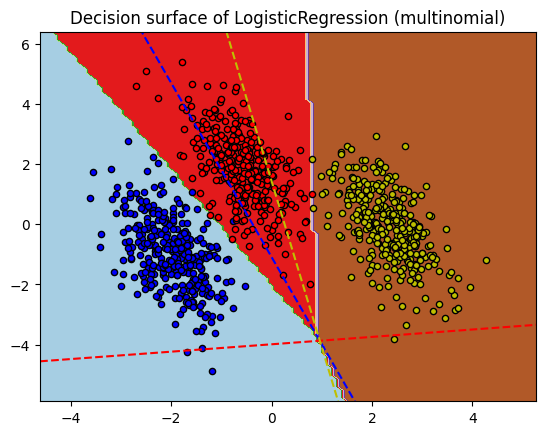

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

clf = LogisticRegression(
        solver="sag", max_iter=100, random_state=42, multi_class="multinomial"
    ).fit(X, y)

# print the training scores
print("training score : %.3f (%s)" % (clf.score(X, y), "multinomial"))

_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict", cmap=plt.cm.Paired, ax=ax)
plt.title("Decision surface of LogisticRegression (%s)" % "multinomial")
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20)

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_
print(xmin, xmax)
print(ymin, ymax)
print('======')
print(coef)
print(intercept)
def plot_hyperplane(c, color):
  w = - (coef[c, 0] - coef[(c+1) % 3, 0]) / (coef[c, 1] - coef[(c+1) % 3, 1])
  b = 
  def line(x0):
      return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

  plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color, label=f"{w}x + {b}")

for i, color in zip(clf.classes_, colors):
  plot_hyperplane(i, color)